# Code by Noureddine Sedki

## Binary classification problem

### Dataset :

We study first a binary classification problem, performed by a neural network. Each input has two real features, and the output can be only 0 or 1. The training set contains 4000 examples, and the validation set, 1000.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Display figures on jupyter notebook
%matplotlib inline

In [2]:
# Define a function to generate the dataset, in the form of two interlaced spirals
def spiral(phi):
    x = (phi+1)*torch.cos(phi)
    y = phi*torch.sin(phi)
    return torch.cat((x, y), dim=1)

def generate_data(num_data):
    angles = torch.empty((num_data, 1)).uniform_(1, 15)
    data = spiral(angles)
    # add some noise to the data
    data += torch.empty((num_data, 2)).normal_(0.0, 0.4)
    labels = torch.zeros((num_data,), dtype=torch.int)
    # flip half of the points to create two classes
    data[num_data//2:,:] *= -1
    labels[num_data//2:] = 1
    return data, labels

In [3]:
# Generate the training set with 4000 examples by function generate_data

X_train, y_train = generate_data(4000)
X_train.size()

torch.Size([4000, 2])

In [4]:
# Define the vis_data function to visualize the dataset
def vis_data(X, y):
    plt.figure(figsize=(5, 5))
    plt.plot(X[y==1, 0], X[y==1, 1], 'r+') #Examples are represented as red plusses for label 1
    plt.plot(X[y==0, 0], X[y==0, 1], 'b+') #Examples are represented as blue plusses for label 0 

We can now invoke the `vis_data` function on the dataset previously generated to see what it looks like:

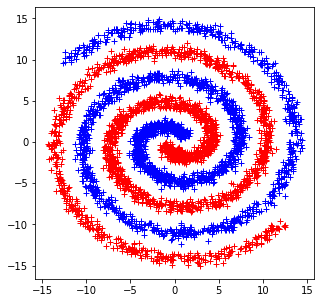

In [5]:
vis_data(X_train, y_train) # visualize training set

We use the `TensorDataset` wrapper from pytorch, so that the framework can easily understand our tensors as a proper dataset.

In [6]:
from torch.utils.data import TensorDataset, DataLoader
training_set = TensorDataset(X_train, y_train)

###  Training the model with a neural network

Here is a skeleton of a neural network with a single layer (thus: a linear classifier). This is the model you'll work on to improve it during this exercise.

Look at the code and run it to see the structure, then follow the questions below to iteratively improve the model.

In [7]:
import torch.nn as nn
import torch.nn.functional as F

At the first step, we define a neural network with just two layers. A useful tutorial for constructing model can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [8]:
# Basic network structure with a single layer
class Model(nn.Module):
    
    def __init__(self):
        super(Model, self).__init__()
        # A single linear layer
        # The model has 2 inputs (the coordinates of the point) and an output (the prediction)
        self.l1 = nn.Linear(2, 10)
        self.l2 = nn.Linear(10, 1)
     
        
    def forward(self, inputs):
        # We want the model to predict 0 for one class and 1 for the other class
        # A Sigmoid activation function seems appropriate
        h = torch.relu(self.l1(inputs))
        outputs = torch.sigmoid(self.l2(h))
        
        return outputs

In [9]:
# Create the model: 
model = Model()

# Choose the hyperparameters for training: 
num_epochs = 10
batch_size = 10

# Training criterion. This one is a mean squared error (MSE) loss between the output
# of the network and the target label
criterion = nn.MSELoss()

# Use SGD optimizer with a learning rate of 0.01
# It is initialized on our model
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

#### Training the defined model
More information can be found [here](https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py).

In [10]:
# define a function for training
model.train()
def train(num_epochs, batch_size, criterion, optimizer, model, dataset):
    train_error = []
    train_loader = DataLoader(dataset, batch_size, shuffle=True)
    model.train()
    for epoch in range(num_epochs):
        epoch_average_loss = 0.0
        for (X_batch, y_real) in train_loader:
            y_pre = model(X_batch).view(-1)
            loss = criterion(y_pre, y_real.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_average_loss += loss.item() * batch_size / len(dataset)
        train_error.append(epoch_average_loss)
        print('Epoch [{}/{}], Loss: {:.4f}'
                    .format(epoch+1, num_epochs, epoch_average_loss))
    return train_error

In [11]:
train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)

Epoch [1/10], Loss: 0.2547
Epoch [2/10], Loss: 0.2477
Epoch [3/10], Loss: 0.2471
Epoch [4/10], Loss: 0.2459
Epoch [5/10], Loss: 0.2451
Epoch [6/10], Loss: 0.2452
Epoch [7/10], Loss: 0.2443
Epoch [8/10], Loss: 0.2442
Epoch [9/10], Loss: 0.2438
Epoch [10/10], Loss: 0.2434


Text(0.5, 1.0, 'Visualization of convergence')

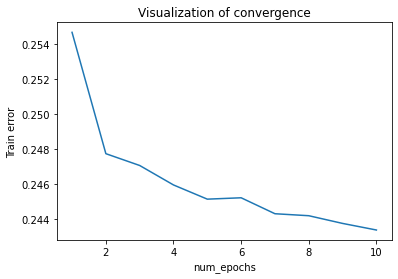

In [12]:
# plot the training error wrt. the number of epochs: 
plt.plot(range(1, num_epochs+1), train_error)
plt.xlabel("num_epochs")
plt.ylabel("Train error")
plt.title("Visualization of convergence")

#### Evaluate the model on the validation set

In [13]:
# Generate 1000 validation data:
X_val, y_val = generate_data(1000)

In [14]:
# Calculate the accuracy on validation set to evaluate the model by the function accuracy
def accuracy(y_real, y_pre):
    y_pre[y_pre<0.5] = 0
    y_pre[y_pre>=0.5] = 1

    acc = 1 - torch.sum(torch.abs(y_pre - y_real))/len(y_pre)
    print('Accuracy of the network on the 1000 validation data: {:.2f} %'.format(acc.item()*100))
    return acc.item()

In [15]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
accuracy(y_val, y_pre)

Accuracy of the network on the 1000 validation data: 56.00 %


0.5600000023841858

In [64]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_val).view(-1)
accuracy(y_val, y_pre)


Accuracy of the network on the 1000 validation data: 56.20 %


0.562000036239624

In [16]:
# Compare the prediction with real labels

def compare_pred(X, y_real, y_pre):
    plt.figure(figsize=(10, 5))

    plt.subplot(121)
    plt.plot(X[y_real==1, 0], X[y_real==1, 1], 'r+') #Examples are represented as a red plusses for label 1
    plt.plot(X[y_real==0, 0], X[y_real==0, 1], 'b+') #Examples are represented as a blue plusses for label 0
    plt.title("real data")

    plt.subplot(122)
    plt.plot(X[y_pre==1, 0], X[y_pre==1, 1], 'r+')
    plt.plot(X[y_pre==0, 0], X[y_pre==0, 1], 'b+')
    plt.title("prediciton results")
    plt.show()

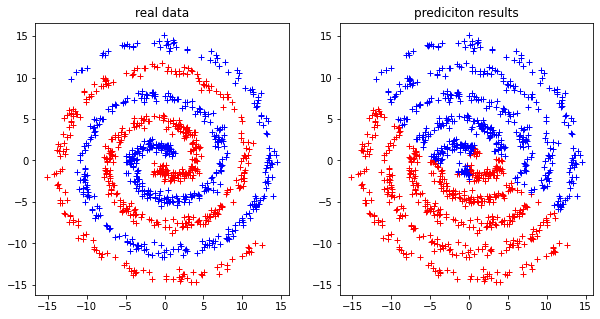

In [17]:
compare_pred(X_val, y_val, y_pre)

### Exercise 1: Impact of the architecture of the model

The class `Model` is the definition of your model. You can now modify it to try out different architectures and
see the impact of the following factors:

* Try to add more layers (1, 2, 3, more ?)
* Try to different activation functions ([sigmoid](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.sigmoid), [tanh](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.tanh), [relu](https://pytorch.org/docs/stable/nn.functional.html#torch.nn.functional.relu), etc.)
* Try to change the number of neurons for each layer (5, 10, 20, more ?)

In [18]:
class MultiLayerClassifier(nn.Module):
  def __init__(self, hidden_dim, n_layers, activation):
    super(MultiLayerClassifier, self).__init__()
    self.activation = activation()

    layers = [nn.Linear(2, hidden_dim), self.activation]
    for _ in range(n_layers-1):
      layers += [nn.Linear(hidden_dim, hidden_dim), self.activation]
    layers += [nn.Linear(hidden_dim, 1)]

    self.multi_layers = nn.Sequential(*layers)
    
  def forward(self, x):
    return torch.sigmoid(self.multi_layers(x))

In [19]:
(X_v, y_v) = generate_data(1000)

In [20]:
def train_and_evaluate_model(model, num_epochs=10, batch_size=10, lr=0.01, Validation_set = (X_v, y_v) , criterion=nn.MSELoss , Optimizer = torch.optim.SGD):
    criterion = criterion()
    optimizer = Optimizer(model.parameters(), lr=lr)
    
    train_error = train(num_epochs, batch_size, criterion, optimizer, model, training_set)
    
    # plt.figure()
    # plt.plot(range(1, num_epochs+1), train_error)
    # plt.xlabel("num_epochs")
    # plt.ylabel("Train error")
    # plt.title("Visualization of convergence")
    # plt.show()
    
    X_val, y_val = (X_v, y_v)
    model.eval() # set the model to test mode
    with torch.no_grad():
        y_pre = model(X_val).view(-1)
    
    acc= accuracy(y_val, y_pre)
    # compare_pred(X_val, y_val, y_pre)
    return train_error , 100*acc

In [21]:
activation = nn.Sigmoid
trial = {'models':[],'train_errors':[],'acc':[]}
for n_layers in [1,2,3,4]:
    
    model = MultiLayerClassifier(10,n_layers, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial['models'].append(model)
    trial['train_errors'].append(train_error)
    trial['acc'].append(acc)



Epoch [1/10], Loss: 0.2544
Epoch [2/10], Loss: 0.2488
Epoch [3/10], Loss: 0.2479
Epoch [4/10], Loss: 0.2475
Epoch [5/10], Loss: 0.2472
Epoch [6/10], Loss: 0.2470
Epoch [7/10], Loss: 0.2468
Epoch [8/10], Loss: 0.2467
Epoch [9/10], Loss: 0.2466
Epoch [10/10], Loss: 0.2465
Accuracy of the network on the 1000 validation data: 56.70 %
Epoch [1/10], Loss: 0.2515
Epoch [2/10], Loss: 0.2500
Epoch [3/10], Loss: 0.2499
Epoch [4/10], Loss: 0.2498
Epoch [5/10], Loss: 0.2497
Epoch [6/10], Loss: 0.2497
Epoch [7/10], Loss: 0.2496
Epoch [8/10], Loss: 0.2495
Epoch [9/10], Loss: 0.2495
Epoch [10/10], Loss: 0.2494
Accuracy of the network on the 1000 validation data: 50.50 %
Epoch [1/10], Loss: 0.2595
Epoch [2/10], Loss: 0.2505
Epoch [3/10], Loss: 0.2501
Epoch [4/10], Loss: 0.2501
Epoch [5/10], Loss: 0.2501
Epoch [6/10], Loss: 0.2501
Epoch [7/10], Loss: 0.2501
Epoch [8/10], Loss: 0.2501
Epoch [9/10], Loss: 0.2501
Epoch [10/10], Loss: 0.2501
Accuracy of the network on the 1000 validation data: 50.00 %
Epoc

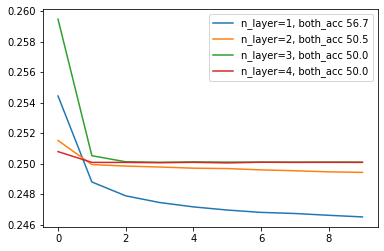

In [22]:
for i,error in enumerate(trial['train_errors']):

    acc = str(round(trial['acc'][i],2))
    plt.plot(error,label="n_layer="+str(i+1)+", both_acc "+acc)
    plt.legend()
    
plt.show()

In [72]:
activation = nn.Sigmoid
trial2 = {'models':[],'train_errors':[],'acc':[]}
for n_neurons in [5,10,20,50,100]:
    
    model = MultiLayerClassifier(n_neurons,2, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial2['models'].append(model)
    trial2['train_errors'].append(train_error)
    trial2['acc'].append(acc)

Epoch [1/10], Loss: 0.2511
Epoch [2/10], Loss: 0.2500
Epoch [3/10], Loss: 0.2498
Epoch [4/10], Loss: 0.2498
Epoch [5/10], Loss: 0.2498
Epoch [6/10], Loss: 0.2498
Epoch [7/10], Loss: 0.2497
Epoch [8/10], Loss: 0.2497
Epoch [9/10], Loss: 0.2497
Epoch [10/10], Loss: 0.2497
Accuracy of the network on the 1000 validation data: 53.50 %
Epoch [1/10], Loss: 0.2544
Epoch [2/10], Loss: 0.2501
Epoch [3/10], Loss: 0.2500
Epoch [4/10], Loss: 0.2500
Epoch [5/10], Loss: 0.2500
Epoch [6/10], Loss: 0.2499
Epoch [7/10], Loss: 0.2499
Epoch [8/10], Loss: 0.2499
Epoch [9/10], Loss: 0.2499
Epoch [10/10], Loss: 0.2498
Accuracy of the network on the 1000 validation data: 51.30 %
Epoch [1/10], Loss: 0.2509
Epoch [2/10], Loss: 0.2507
Epoch [3/10], Loss: 0.2506
Epoch [4/10], Loss: 0.2505
Epoch [5/10], Loss: 0.2504
Epoch [6/10], Loss: 0.2503
Epoch [7/10], Loss: 0.2502
Epoch [8/10], Loss: 0.2501
Epoch [9/10], Loss: 0.2501
Epoch [10/10], Loss: 0.2500
Accuracy of the network on the 1000 validation data: 51.10 %
Epoc

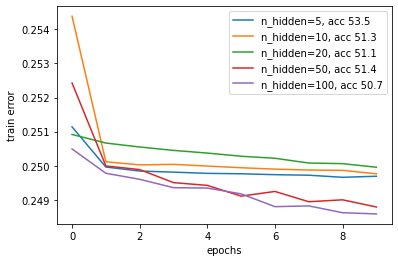

In [73]:
hiddens= [5,10,20,50,100]

for i,n_hidden in enumerate(hiddens):

    both_acc = str(round(trial2['acc'][i],2))
    error = trial2['train_errors'][i]
    plt.plot(error,label="n_hidden="+str(n_hidden)+", acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    
    plt.legend()
    
plt.show()

In [74]:
activation = nn.Tanh
trial = {'models':[],'train_errors':[],'acc':[]}
for n_layers in [1,2,3,4]:
    
    model = MultiLayerClassifier(10,n_layers, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial['models'].append(model)
    trial['train_errors'].append(train_error)
    trial['acc'].append(acc)


Epoch [1/10], Loss: 0.2492
Epoch [2/10], Loss: 0.2468
Epoch [3/10], Loss: 0.2455
Epoch [4/10], Loss: 0.2446
Epoch [5/10], Loss: 0.2440
Epoch [6/10], Loss: 0.2435
Epoch [7/10], Loss: 0.2427
Epoch [8/10], Loss: 0.2426
Epoch [9/10], Loss: 0.2422
Epoch [10/10], Loss: 0.2419
Accuracy of the network on the 1000 validation data: 58.70 %
Epoch [1/10], Loss: 0.2508
Epoch [2/10], Loss: 0.2485
Epoch [3/10], Loss: 0.2478
Epoch [4/10], Loss: 0.2475
Epoch [5/10], Loss: 0.2472
Epoch [6/10], Loss: 0.2471
Epoch [7/10], Loss: 0.2469
Epoch [8/10], Loss: 0.2467
Epoch [9/10], Loss: 0.2466
Epoch [10/10], Loss: 0.2464
Accuracy of the network on the 1000 validation data: 55.10 %
Epoch [1/10], Loss: 0.2518
Epoch [2/10], Loss: 0.2499
Epoch [3/10], Loss: 0.2494
Epoch [4/10], Loss: 0.2492
Epoch [5/10], Loss: 0.2490
Epoch [6/10], Loss: 0.2488
Epoch [7/10], Loss: 0.2487
Epoch [8/10], Loss: 0.2486
Epoch [9/10], Loss: 0.2484
Epoch [10/10], Loss: 0.2484
Accuracy of the network on the 1000 validation data: 54.00 %
Epoc

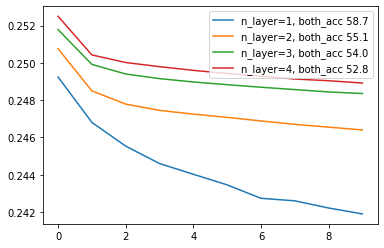

In [75]:
for i,error in enumerate(trial['train_errors']):

    acc = str(round(trial['acc'][i],2))
    plt.plot(error,label="n_layer="+str(i+1)+", both_acc "+acc)
    plt.legend()
    
plt.show()

In [76]:
activation = nn.Tanh
trial2 = {'models':[],'train_errors':[],'acc':[]}
for n_neurons in [5,10,20,50,100]:
    
    model = MultiLayerClassifier(n_neurons,2, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial2['models'].append(model)
    trial2['train_errors'].append(train_error)
    trial2['acc'].append(acc)

Epoch [1/10], Loss: 0.2530
Epoch [2/10], Loss: 0.2509
Epoch [3/10], Loss: 0.2499
Epoch [4/10], Loss: 0.2494
Epoch [5/10], Loss: 0.2491
Epoch [6/10], Loss: 0.2488
Epoch [7/10], Loss: 0.2486
Epoch [8/10], Loss: 0.2484
Epoch [9/10], Loss: 0.2483
Epoch [10/10], Loss: 0.2482
Accuracy of the network on the 1000 validation data: 51.10 %
Epoch [1/10], Loss: 0.2529
Epoch [2/10], Loss: 0.2503
Epoch [3/10], Loss: 0.2489
Epoch [4/10], Loss: 0.2480
Epoch [5/10], Loss: 0.2474
Epoch [6/10], Loss: 0.2469
Epoch [7/10], Loss: 0.2464
Epoch [8/10], Loss: 0.2460
Epoch [9/10], Loss: 0.2454
Epoch [10/10], Loss: 0.2449
Accuracy of the network on the 1000 validation data: 57.10 %
Epoch [1/10], Loss: 0.2504
Epoch [2/10], Loss: 0.2482
Epoch [3/10], Loss: 0.2476
Epoch [4/10], Loss: 0.2472
Epoch [5/10], Loss: 0.2467
Epoch [6/10], Loss: 0.2463
Epoch [7/10], Loss: 0.2459
Epoch [8/10], Loss: 0.2454
Epoch [9/10], Loss: 0.2450
Epoch [10/10], Loss: 0.2444
Accuracy of the network on the 1000 validation data: 56.20 %
Epoc

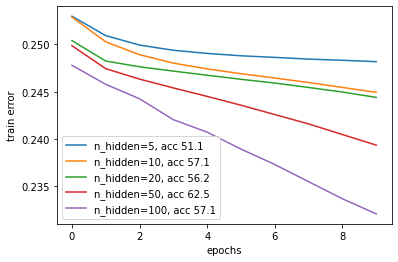

In [77]:
hiddens= [5,10,20,50,100]

for i,n_hidden in enumerate(hiddens):

    both_acc = str(round(trial2['acc'][i],2))
    error = trial2['train_errors'][i]
    plt.plot(error,label="n_hidden="+str(n_hidden)+", acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    
    plt.legend()
    
plt.show()

In [78]:
activation = nn.ReLU
trial2 = {'models':[],'train_errors':[],'acc':[]}
for n_neurons in [5,10,20,50,100]:
    
    model = MultiLayerClassifier(n_neurons,2, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial2['models'].append(model)
    trial2['train_errors'].append(train_error)
    trial2['acc'].append(acc)

Epoch [1/10], Loss: 0.2485
Epoch [2/10], Loss: 0.2478
Epoch [3/10], Loss: 0.2472
Epoch [4/10], Loss: 0.2468
Epoch [5/10], Loss: 0.2464
Epoch [6/10], Loss: 0.2462
Epoch [7/10], Loss: 0.2460
Epoch [8/10], Loss: 0.2457
Epoch [9/10], Loss: 0.2456
Epoch [10/10], Loss: 0.2454
Accuracy of the network on the 1000 validation data: 55.30 %
Epoch [1/10], Loss: 0.2585
Epoch [2/10], Loss: 0.2468
Epoch [3/10], Loss: 0.2459
Epoch [4/10], Loss: 0.2455
Epoch [5/10], Loss: 0.2452
Epoch [6/10], Loss: 0.2450
Epoch [7/10], Loss: 0.2446
Epoch [8/10], Loss: 0.2443
Epoch [9/10], Loss: 0.2436
Epoch [10/10], Loss: 0.2439
Accuracy of the network on the 1000 validation data: 55.80 %
Epoch [1/10], Loss: 0.2514
Epoch [2/10], Loss: 0.2463
Epoch [3/10], Loss: 0.2455
Epoch [4/10], Loss: 0.2449
Epoch [5/10], Loss: 0.2444
Epoch [6/10], Loss: 0.2440
Epoch [7/10], Loss: 0.2436
Epoch [8/10], Loss: 0.2433
Epoch [9/10], Loss: 0.2427
Epoch [10/10], Loss: 0.2424
Accuracy of the network on the 1000 validation data: 56.30 %
Epoc

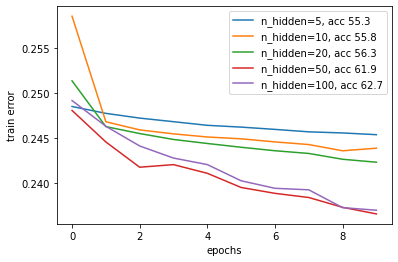

In [79]:
hiddens= [5,10,20,50,100]

for i,n_hidden in enumerate(hiddens):

    both_acc = str(round(trial2['acc'][i],2))
    error = trial2['train_errors'][i]
    plt.plot(error,label="n_hidden="+str(n_hidden)+", acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    
    plt.legend()
    
plt.show()

In [80]:
activation = nn.ReLU
trial = {'models':[],'train_errors':[],'acc':[]}
for n_layers in [1,2,3,4]:
    
    model = MultiLayerClassifier(10,n_layers, activation)
    train_error , acc = train_and_evaluate_model(model)
    trial['models'].append(model)
    trial['train_errors'].append(train_error)
    trial['acc'].append(acc)


Epoch [1/10], Loss: 0.2617
Epoch [2/10], Loss: 0.2499
Epoch [3/10], Loss: 0.2484
Epoch [4/10], Loss: 0.2480
Epoch [5/10], Loss: 0.2472
Epoch [6/10], Loss: 0.2470
Epoch [7/10], Loss: 0.2467
Epoch [8/10], Loss: 0.2465
Epoch [9/10], Loss: 0.2465
Epoch [10/10], Loss: 0.2462
Accuracy of the network on the 1000 validation data: 51.70 %
Epoch [1/10], Loss: 0.2485
Epoch [2/10], Loss: 0.2459
Epoch [3/10], Loss: 0.2452
Epoch [4/10], Loss: 0.2447
Epoch [5/10], Loss: 0.2442
Epoch [6/10], Loss: 0.2438
Epoch [7/10], Loss: 0.2433
Epoch [8/10], Loss: 0.2432
Epoch [9/10], Loss: 0.2427
Epoch [10/10], Loss: 0.2421
Accuracy of the network on the 1000 validation data: 55.90 %
Epoch [1/10], Loss: 0.2492
Epoch [2/10], Loss: 0.2471
Epoch [3/10], Loss: 0.2463
Epoch [4/10], Loss: 0.2459
Epoch [5/10], Loss: 0.2455
Epoch [6/10], Loss: 0.2452
Epoch [7/10], Loss: 0.2449
Epoch [8/10], Loss: 0.2447
Epoch [9/10], Loss: 0.2446
Epoch [10/10], Loss: 0.2444
Accuracy of the network on the 1000 validation data: 55.00 %
Epoc

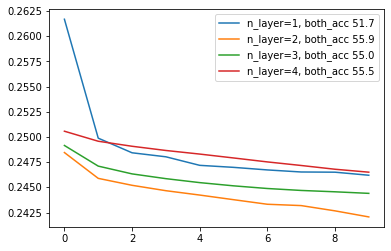

In [81]:
for i,error in enumerate(trial['train_errors']):

    acc = str(round(trial['acc'][i],2))
    plt.plot(error,label="n_layer="+str(i+1)+", both_acc "+acc)
    plt.legend()
    
plt.show()

In [82]:
trialx = {'models':[],'train_errors':[],'acc':[]}
acts = [nn.Sigmoid,nn.ReLU,nn.Tanh]
for act in acts:
    model = MultiLayerClassifier(100,3, act)
    train_error , acc = train_and_evaluate_model(model,num_epochs=20)
    trialx['models'].append(model)
    trialx['train_errors'].append(train_error)
    trialx['acc'].append(acc)

Epoch [1/20], Loss: 0.2509
Epoch [2/20], Loss: 0.2505
Epoch [3/20], Loss: 0.2507
Epoch [4/20], Loss: 0.2503
Epoch [5/20], Loss: 0.2503
Epoch [6/20], Loss: 0.2505
Epoch [7/20], Loss: 0.2506
Epoch [8/20], Loss: 0.2503
Epoch [9/20], Loss: 0.2506
Epoch [10/20], Loss: 0.2502
Epoch [11/20], Loss: 0.2504
Epoch [12/20], Loss: 0.2504
Epoch [13/20], Loss: 0.2503
Epoch [14/20], Loss: 0.2502
Epoch [15/20], Loss: 0.2504
Epoch [16/20], Loss: 0.2504
Epoch [17/20], Loss: 0.2502
Epoch [18/20], Loss: 0.2504
Epoch [19/20], Loss: 0.2503
Epoch [20/20], Loss: 0.2503
Accuracy of the network on the 1000 validation data: 50.00 %
Epoch [1/20], Loss: 0.2459
Epoch [2/20], Loss: 0.2447
Epoch [3/20], Loss: 0.2439
Epoch [4/20], Loss: 0.2431
Epoch [5/20], Loss: 0.2425
Epoch [6/20], Loss: 0.2420
Epoch [7/20], Loss: 0.2415
Epoch [8/20], Loss: 0.2409
Epoch [9/20], Loss: 0.2399
Epoch [10/20], Loss: 0.2397
Epoch [11/20], Loss: 0.2387
Epoch [12/20], Loss: 0.2379
Epoch [13/20], Loss: 0.2369
Epoch [14/20], Loss: 0.2361
Epoch

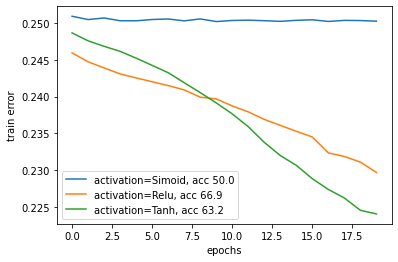

In [83]:
acts = ['Simoid' , 'Relu' , 'Tanh']
for i,act in enumerate(acts):

    both_acc = str(round(trialx['acc'][i],1))
    error = trialx['train_errors'][i]
    plt.plot(error,label="activation="+act+", acc "+both_acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

### Exercise 2: Impact of the optimizer

Retrain the model by using different parameters of the optimizer, you can change its parameter in the cell initializing it, after the definition of your model.

* Use different batch size from 10 to 400
* Try different values of the learning rate (between 0.001 and 10), and see how these impact the trainig process. Do all network architectures react the same way to different learning rates?
* Change the duration of the training by increasing the number of epochs
* Try other optimizers, such as [Adam](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam) or [RMSprop](https://pytorch.org/docs/stable/optim.html?highlight=rmsprop#torch.optim.RMSprop)

**Note:** These changes may interact with your previous choices of architectures, and you may need to change them as well!

In [84]:
batch_sizes = [5,10, 50, 100, 200, 400]
trialx = {'models':[],'train_errors':[],'acc':[]}
for batch_size in batch_sizes:
    model = MultiLayerClassifier(100,3, nn.Tanh)
    train_error , acc = train_and_evaluate_model(model,batch_size=batch_size)
    trialx['models'].append(model)
    trialx['train_errors'].append(train_error)
    trialx['acc'].append(acc)

Epoch [1/10], Loss: 0.2478
Epoch [2/10], Loss: 0.2462
Epoch [3/10], Loss: 0.2445
Epoch [4/10], Loss: 0.2426
Epoch [5/10], Loss: 0.2397
Epoch [6/10], Loss: 0.2367
Epoch [7/10], Loss: 0.2344
Epoch [8/10], Loss: 0.2304
Epoch [9/10], Loss: 0.2285
Epoch [10/10], Loss: 0.2253
Accuracy of the network on the 1000 validation data: 67.80 %
Epoch [1/10], Loss: 0.2482
Epoch [2/10], Loss: 0.2473
Epoch [3/10], Loss: 0.2467
Epoch [4/10], Loss: 0.2460
Epoch [5/10], Loss: 0.2455
Epoch [6/10], Loss: 0.2448
Epoch [7/10], Loss: 0.2437
Epoch [8/10], Loss: 0.2431
Epoch [9/10], Loss: 0.2419
Epoch [10/10], Loss: 0.2408
Accuracy of the network on the 1000 validation data: 62.40 %
Epoch [1/10], Loss: 0.2480
Epoch [2/10], Loss: 0.2474
Epoch [3/10], Loss: 0.2472
Epoch [4/10], Loss: 0.2471
Epoch [5/10], Loss: 0.2469
Epoch [6/10], Loss: 0.2467
Epoch [7/10], Loss: 0.2466
Epoch [8/10], Loss: 0.2464
Epoch [9/10], Loss: 0.2463
Epoch [10/10], Loss: 0.2462
Accuracy of the network on the 1000 validation data: 56.20 %
Epoc

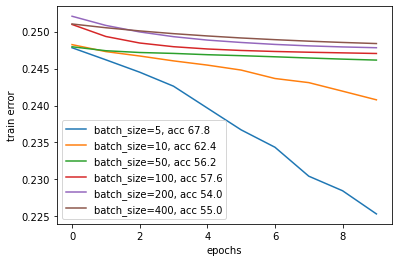

In [85]:
for i,b_size in enumerate(batch_sizes):

    acc = str(round(trialx['acc'][i],1))
    error = trialx['train_errors'][i]
    plt.plot(error,label="batch_size="+str(b_size)+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt
    plt.legend()
    
plt.show()

In [86]:
trial4 = {'models':[],'train_errors':[],'acc':[]}
lr_rates = [1e-4,1e-3,1e-2,1e-1,1,10]

for lr in lr_rates:

    model = MultiLayerClassifier(100,3, nn.Tanh)
    train_error , acc = train_and_evaluate_model(model,batch_size=5 , lr = lr)
    trial4['models'].append(model)
    trial4['train_errors'].append(train_error)
    trial4['acc'].append(acc)

Epoch [1/10], Loss: 0.2517
Epoch [2/10], Loss: 0.2514
Epoch [3/10], Loss: 0.2512
Epoch [4/10], Loss: 0.2509
Epoch [5/10], Loss: 0.2507
Epoch [6/10], Loss: 0.2505
Epoch [7/10], Loss: 0.2503
Epoch [8/10], Loss: 0.2501
Epoch [9/10], Loss: 0.2500
Epoch [10/10], Loss: 0.2498
Accuracy of the network on the 1000 validation data: 50.90 %
Epoch [1/10], Loss: 0.2509
Epoch [2/10], Loss: 0.2492
Epoch [3/10], Loss: 0.2485
Epoch [4/10], Loss: 0.2482
Epoch [5/10], Loss: 0.2480
Epoch [6/10], Loss: 0.2478
Epoch [7/10], Loss: 0.2477
Epoch [8/10], Loss: 0.2475
Epoch [9/10], Loss: 0.2474
Epoch [10/10], Loss: 0.2472
Accuracy of the network on the 1000 validation data: 55.60 %
Epoch [1/10], Loss: 0.2480
Epoch [2/10], Loss: 0.2463
Epoch [3/10], Loss: 0.2450
Epoch [4/10], Loss: 0.2438
Epoch [5/10], Loss: 0.2417
Epoch [6/10], Loss: 0.2395
Epoch [7/10], Loss: 0.2369
Epoch [8/10], Loss: 0.2344
Epoch [9/10], Loss: 0.2323
Epoch [10/10], Loss: 0.2295
Accuracy of the network on the 1000 validation data: 62.10 %
Epoc

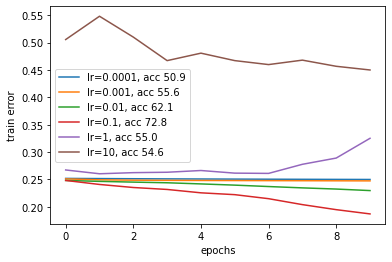

In [87]:
for i,lr in enumerate(lr_rates):

    acc = str(round(trial4['acc'][i],1))
    error = trial4['train_errors'][i]
    plt.plot(error,label="lr="+str(lr)+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

In [88]:
trial4 = {'models':[],'train_errors':[],'acc':[]}
num_epochs  = [5, 10, 20, 50 ]

for E in num_epochs:

    model = MultiLayerClassifier(100,3, nn.ReLU)
    train_error , acc = train_and_evaluate_model(model,batch_size=10 , lr = 0.1 , num_epochs= E)
    trial4['models'].append(model)
    trial4['train_errors'].append(train_error)
    trial4['acc'].append(acc)

Epoch [1/5], Loss: 0.2469
Epoch [2/5], Loss: 0.2421
Epoch [3/5], Loss: 0.2368
Epoch [4/5], Loss: 0.2262
Epoch [5/5], Loss: 0.2086
Accuracy of the network on the 1000 validation data: 70.90 %
Epoch [1/10], Loss: 0.2489
Epoch [2/10], Loss: 0.2446
Epoch [3/10], Loss: 0.2412
Epoch [4/10], Loss: 0.2353
Epoch [5/10], Loss: 0.2202
Epoch [6/10], Loss: 0.2042
Epoch [7/10], Loss: 0.1842
Epoch [8/10], Loss: 0.1714
Epoch [9/10], Loss: 0.1625
Epoch [10/10], Loss: 0.1511
Accuracy of the network on the 1000 validation data: 77.40 %
Epoch [1/20], Loss: 0.2470
Epoch [2/20], Loss: 0.2438
Epoch [3/20], Loss: 0.2409
Epoch [4/20], Loss: 0.2313
Epoch [5/20], Loss: 0.2170
Epoch [6/20], Loss: 0.1958
Epoch [7/20], Loss: 0.1783
Epoch [8/20], Loss: 0.1687
Epoch [9/20], Loss: 0.1611
Epoch [10/20], Loss: 0.1538
Epoch [11/20], Loss: 0.1442
Epoch [12/20], Loss: 0.1388
Epoch [13/20], Loss: 0.1325
Epoch [14/20], Loss: 0.1268
Epoch [15/20], Loss: 0.1289
Epoch [16/20], Loss: 0.1214
Epoch [17/20], Loss: 0.1019
Epoch [18/

No handles with labels found to put in legend.


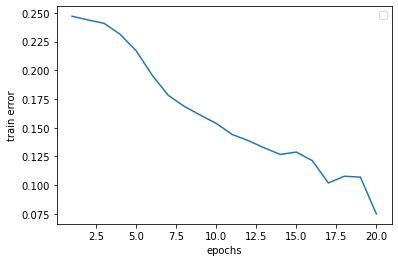

In [89]:

plt.plot( range(1,21),  trial4['train_errors'][2])
plt.xlabel("epochs")
plt.ylabel("train error")
plt.legend()
    
plt.show()

In [90]:
trial4 = {'models':[],'train_errors':[],'acc':[]}
opts_str = ['SGD','RMSprop','Adam']

for opt_str in opts_str:

    
    if opt_str == 'SGD': 
      opt = torch.optim.SGD
      LR= 0.1
    if opt_str == 'RMSprop' : 
      opt = torch.optim.RMSprop
      LR=0.001

    if opt_str == 'Adam' : 
      opt=torch.optim.Adam
      LR=0.001
    
    model = MultiLayerClassifier(100,3, nn.Tanh)
    train_error , acc = train_and_evaluate_model(model,batch_size=10 , lr = LR , num_epochs= 20, Optimizer=opt)
    trial4['models'].append(model)
    trial4['train_errors'].append(train_error)
    trial4['acc'].append(acc)
    

Epoch [1/20], Loss: 0.2480
Epoch [2/20], Loss: 0.2420
Epoch [3/20], Loss: 0.2352
Epoch [4/20], Loss: 0.2322
Epoch [5/20], Loss: 0.2281
Epoch [6/20], Loss: 0.2253
Epoch [7/20], Loss: 0.2208
Epoch [8/20], Loss: 0.2188
Epoch [9/20], Loss: 0.2152
Epoch [10/20], Loss: 0.2091
Epoch [11/20], Loss: 0.2066
Epoch [12/20], Loss: 0.2019
Epoch [13/20], Loss: 0.1976
Epoch [14/20], Loss: 0.1915
Epoch [15/20], Loss: 0.1857
Epoch [16/20], Loss: 0.1805
Epoch [17/20], Loss: 0.1744
Epoch [18/20], Loss: 0.1703
Epoch [19/20], Loss: 0.1676
Epoch [20/20], Loss: 0.1645
Accuracy of the network on the 1000 validation data: 73.90 %
Epoch [1/20], Loss: 0.2457
Epoch [2/20], Loss: 0.2281
Epoch [3/20], Loss: 0.2164
Epoch [4/20], Loss: 0.2037
Epoch [5/20], Loss: 0.1841
Epoch [6/20], Loss: 0.1590
Epoch [7/20], Loss: 0.1211
Epoch [8/20], Loss: 0.0899
Epoch [9/20], Loss: 0.0752
Epoch [10/20], Loss: 0.0443
Epoch [11/20], Loss: 0.0382
Epoch [12/20], Loss: 0.0334
Epoch [13/20], Loss: 0.0301
Epoch [14/20], Loss: 0.0320
Epoch

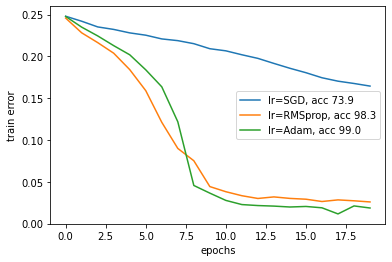

In [91]:
for i,opt in enumerate(opts_str):

    acc = str(round(trial4['acc'][i],1))
    error = trial4['train_errors'][i]
    plt.plot(error,label="lr="+opt+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 3: Impact of the loss function

The current model uses a mean square error (MSE) loss. While this loss can be used in this case, it is now rarely used for classification, and instead a Binary Cross Entropy (BCE) is used. It consists in interpreting the output of the network as the probability $p(y | x)$ of the point $x$ to belong to the class $y$, and in maximizing the probability to be correct for all samples $x$, that is, in maximizing $\displaystyle \prod_{(x,y) \in Dataset} p(y|x)$. Applying $-\log$ to this quantity, we obtain the following criterion to minimize:

$$ \sum_{(x,y) \in Dataset} - \log p(y | x) $$

This is implemented as such by the [BCELoss](https://pytorch.org/docs/stable/nn.html?highlight=bce#torch.nn.BCELoss) of pytorch. Note that this criterion requires its input to be a probability, i.e. in $[0,1]$, which requires the use of an appropriate activation function beforehand, e.g., a sigmoid.

It turns out that, for numerical stability reasons, it is better to incorporate this sigmoid and the BCELoss into a single function; this is done by the [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html?highlight=bcewithlogit#torch.nn.BCEWithLogitsLoss). Try to replace the MSE by this one and see how this changes the behavior in the network. This can also interact with the changes of the two previous exercices.

**Note:** As a consequence, when using the BCEWithLogitsLoss, the last layer of your network should not be followed by an activation function, as BCEWithLogitsLoss already adds a sigmoid.

In [92]:
class MultiLayerClassifier(nn.Module):
  def __init__(self, hidden_dim, n_layers, activation):
    super(MultiLayerClassifier, self).__init__()
    self.activation = activation()

    layers = [nn.Linear(2, hidden_dim), self.activation]
    for _ in range(n_layers-1):
      layers += [nn.Linear(hidden_dim, hidden_dim), self.activation]
    layers += [nn.Linear(hidden_dim, 1)]

    self.multi_layers = nn.Sequential(*layers)
    
  def forward(self, x):
    return self.multi_layers(x)

In [93]:

trial4 = {'models':[],'train_errors':[],'acc':[]}
opts_str = ['SGD','RMSprop','Adam']

for opt_str in opts_str:

    
    if opt_str == 'SGD': 
      opt = torch.optim.SGD
      LR = 0.1
    if opt_str == 'RMSprop' : 
      opt = torch.optim.RMSprop 
      LR = 0.001
    if opt_str == 'Adam' : 
      opt=torch.optim.Adam 
      LR = 0.001
    
    model = MultiLayerClassifier(100,3, nn.Tanh)
    train_error , acc = train_and_evaluate_model(model,criterion=nn.BCEWithLogitsLoss,batch_size=10 , lr = LR , num_epochs= 20, Optimizer=opt)
    trial4['models'].append(model)
    trial4['train_errors'].append(train_error)
    trial4['acc'].append(acc)
    

Epoch [1/20], Loss: 0.6923
Epoch [2/20], Loss: 0.6819
Epoch [3/20], Loss: 0.6657
Epoch [4/20], Loss: 0.6505
Epoch [5/20], Loss: 0.6344
Epoch [6/20], Loss: 0.6183
Epoch [7/20], Loss: 0.5982
Epoch [8/20], Loss: 0.5794
Epoch [9/20], Loss: 0.5571
Epoch [10/20], Loss: 0.5373
Epoch [11/20], Loss: 0.5175
Epoch [12/20], Loss: 0.5205
Epoch [13/20], Loss: 0.5035
Epoch [14/20], Loss: 0.5387
Epoch [15/20], Loss: 0.5206
Epoch [16/20], Loss: 0.5697
Epoch [17/20], Loss: 0.5067
Epoch [18/20], Loss: 0.5092
Epoch [19/20], Loss: 0.5495
Epoch [20/20], Loss: 0.5143
Accuracy of the network on the 1000 validation data: 76.50 %
Epoch [1/20], Loss: 0.6869
Epoch [2/20], Loss: 0.6579
Epoch [3/20], Loss: 0.6314
Epoch [4/20], Loss: 0.5951
Epoch [5/20], Loss: 0.5483
Epoch [6/20], Loss: 0.4970
Epoch [7/20], Loss: 0.4271
Epoch [8/20], Loss: 0.2842
Epoch [9/20], Loss: 0.1739
Epoch [10/20], Loss: 0.1363
Epoch [11/20], Loss: 0.1435
Epoch [12/20], Loss: 0.1145
Epoch [13/20], Loss: 0.1134
Epoch [14/20], Loss: 0.1099
Epoch

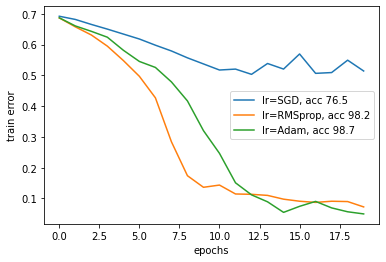

In [94]:
for i,opt in enumerate(opts_str):

    acc = str(round(trial4['acc'][i],1))
    error = trial4['train_errors'][i]
    plt.plot(error,label="lr="+opt+", acc "+acc)
    plt.xlabel("epochs")
    plt.ylabel("train error")
    plt.legend()
    
plt.show()

### Exercise 4: Prediction on test set

Once you have a model that seems satisfying on the validation dataset, you SHOULD evaluate it on a test dataset that has never been used before, to obtain a final accuracy value.

In [95]:
# Here is a test dataset. Use it similarly to the validaiton dataset above
# to compute the final performance of your model
X_test, y_test = generate_data(1000)
opt = torch.optim.RMSprop


model = MultiLayerClassifier(100,3, nn.ReLU)
train_error , acc = train_and_evaluate_model(model,criterion=nn.BCEWithLogitsLoss,batch_size=10 , lr = 0.001 , num_epochs= 20, Optimizer=opt)

Epoch [1/20], Loss: 0.6807
Epoch [2/20], Loss: 0.5643
Epoch [3/20], Loss: 0.4549
Epoch [4/20], Loss: 0.3833
Epoch [5/20], Loss: 0.2911
Epoch [6/20], Loss: 0.1696
Epoch [7/20], Loss: 0.1021
Epoch [8/20], Loss: 0.0685
Epoch [9/20], Loss: 0.0574
Epoch [10/20], Loss: 0.0492
Epoch [11/20], Loss: 0.0418
Epoch [12/20], Loss: 0.0263
Epoch [13/20], Loss: 0.0542
Epoch [14/20], Loss: 0.0218
Epoch [15/20], Loss: 0.0375
Epoch [16/20], Loss: 0.0283
Epoch [17/20], Loss: 0.0272
Epoch [18/20], Loss: 0.0175
Epoch [19/20], Loss: 0.0276
Epoch [20/20], Loss: 0.0304
Accuracy of the network on the 1000 validation data: 99.70 %


Accuracy of the network on the 1000 validation data: 99.70 %


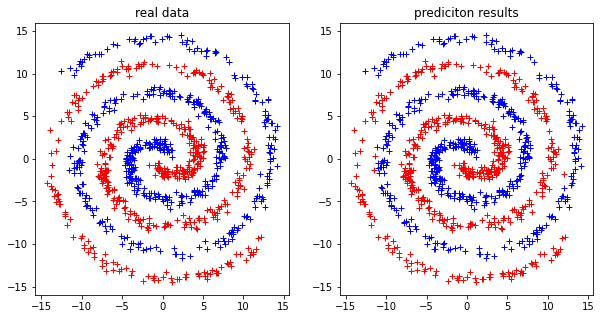

In [96]:
# predict labels for validation set
model.eval() # set the model to test mode
with torch.no_grad():
    y_pre = model(X_test).view(-1)
accuracy(y_test, y_pre
         )
compare_pred(X_test, y_test, y_pre)